## Step 1: import files

In [1]:
import cv2
print(cv2.__version__)

4.4.0


In [2]:
# Get filenames in list
from os import listdir
from os.path import isfile, join
mypath = "dataset/phase1/images"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print(str(len(file_names)) + ' images loaded')


97 images loaded


## Step 2: Sift and Glcm demo on one example image

47

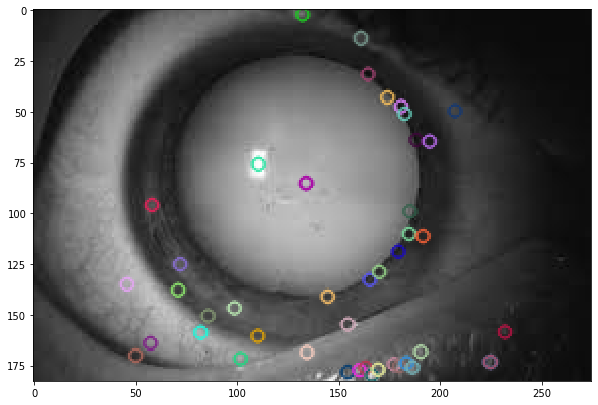

In [3]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)
#reading image
img1 = cv2.imread(mypath+"/"+file_names[21])  
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(gray1,None)

img_1 = cv2.drawKeypoints(gray1,keypoints_1,img1)
plt.imshow(img_1)
img1.shape
len(keypoints_1)

In [4]:
import numpy as np
from skimage.feature import  greycomatrix, greycoprops
from skimage.measure import shannon_entropy
image = cv2.imread(mypath+"/"+file_names[21],0)
img_arr = np.array(image)
print(shannon_entropy(img_arr))
gCoMat = greycomatrix(img_arr, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')[0][0]
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')[0][0]
homogeneity = greycoprops(gCoMat, prop='homogeneity')[0][0]
energy = greycoprops(gCoMat, prop='energy')[0][0]
correlation = greycoprops(gCoMat, prop='correlation')[0][0]
print("contrast: ",contrast)
print("dissimilarity: ",dissimilarity)
print("homogeneity: ",homogeneity)
print("energy: ",energy)
print("correlation: ",correlation)

7.37840706017806
contrast:  31.412348929041524
dissimilarity:  3.0875114674324915
homogeneity:  0.4051366064192086
energy:  0.039446946896192533
correlation:  0.9944224409212229


## Step 3: Sift and glcm on full dataset

In [26]:
import cv2
import numpy as np
from skimage.feature import  greycomatrix, greycoprops
images_sift = []
glcm=[]
labels = []
size = 128
sift = cv2.xfeatures2d.SIFT_create()
cataract=0
normal=0
for i, file in enumerate(file_names):
        image = cv2.imread(mypath+"/"+file,0)
        h,w=image.shape
        if(h>128 and w>128):
            image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
            img_arr = np.array(image)
            gCoMat = greycomatrix(img_arr, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
            contrast = greycoprops(gCoMat, prop='contrast')[0][0]
            dissimilarity = greycoprops(gCoMat, prop='dissimilarity')[0][0]
            homogeneity = greycoprops(gCoMat, prop='homogeneity')[0][0]
            energy = greycoprops(gCoMat, prop='energy')[0][0]
            correlation = greycoprops(gCoMat, prop='correlation')[0][0]
            keypoints, descriptors = sift.detectAndCompute(image,None)
            descriptors=np.array(descriptors)
            descriptors=descriptors.flatten()
            glcm.append([contrast,dissimilarity,homogeneity,energy,correlation])
            images_sift.append(descriptors[:2304])

            #print(descriptors.shape)
            if file_names[i][0] == "c":
                cataract+=1
                labels.append(1)
            if file_names[i][0] == "n":
                normal+=1
                labels.append(0)
          
print("Testing and validation split done!")


Testing and validation split done!


In [27]:
labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [28]:
images_sift=np.array(images_sift)
images_sift.shape





(53, 2304)

In [29]:
glcm=np.array(glcm)
images_sift_glcm=np.concatenate((images_sift,glcm),axis=1)
images_sift_glcm.shape

(53, 2309)

## Step 4: Building various  ML models

In [30]:
from sklearn import preprocessing
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import confusion_matrix  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


rf_class = RandomForestClassifier(n_estimators=100)
svm_rbf=svm.SVC(kernel='rbf',gamma=0.001,C=10)
svm_linear=svm.SVC(kernel='linear',gamma=0.001,C=10)
knn= KNeighborsClassifier(n_neighbors=2, metric='minkowski', p=2) 
log = LogisticRegression(solver='liblinear')

model_names={"Random Forest":rf_class,"SVM RBF":svm_rbf,"SVM_linear":svm_linear,"k nearest neighbor":knn,"logistic regression":log}
    



## Step 5: Testing various model 

In [31]:
def testing(model_name,X_train, X_test, y_train, y_test):
    model=model_names[model_name]
    model.fit(X_train,y_train)
    yhat = model.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, yhat)
    print(model_name,'\tAccuracy: %.3f' % acc)
    print(confusion_matrix(y_test, yhat))
    print("\n\n")
    
    

In [32]:
def result(dataset):
    #Normalization
    #min_max_scaler = preprocessing.StandardScaler()
    #x_scaled = min_max_scaler.fit_transform(dataset)
    
    
    #panda dataframe 
    df=pd.DataFrame(data=dataset)
    df['label']=labels
    df=df.sample(frac=1)
    X=df.drop(['label'], axis = 1)
    y=df['label']
    
    
    #Different model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    for model in ["Random Forest","SVM RBF","SVM_linear","k nearest neighbor","logistic regression"]:
        testing(model,X_train, X_test, y_train, y_test)
    
    
    
    
    



## Testing Sift features

In [33]:
print("Sift testing..........\n")
result(images_sift)


Sift testing..........

Random Forest 	Accuracy: 0.857
[[ 1  2]
 [ 0 11]]



SVM RBF 	Accuracy: 0.786
[[ 0  3]
 [ 0 11]]



SVM_linear 	Accuracy: 0.929
[[ 2  1]
 [ 0 11]]



k nearest neighbor 	Accuracy: 0.929
[[ 2  1]
 [ 0 11]]



logistic regression 	Accuracy: 0.929
[[ 2  1]
 [ 0 11]]





## GLCM features

In [34]:
print("glcm testing..........\n")
result(glcm)

glcm testing..........

Random Forest 	Accuracy: 0.786
[[6 2]
 [1 5]]



SVM RBF 	Accuracy: 0.571
[[3 5]
 [1 5]]



SVM_linear 	Accuracy: 0.786
[[5 3]
 [0 6]]



k nearest neighbor 	Accuracy: 0.643
[[6 2]
 [3 3]]



logistic regression 	Accuracy: 0.643
[[3 5]
 [0 6]]





## sift and glcm combined features

In [35]:
print("sift and glcm combined testing..........\n")
result(images_sift_glcm)

sift and glcm combined testing..........

Random Forest 	Accuracy: 0.786
[[2 3]
 [0 9]]



SVM RBF 	Accuracy: 0.643
[[0 5]
 [0 9]]



SVM_linear 	Accuracy: 0.929
[[4 1]
 [0 9]]



k nearest neighbor 	Accuracy: 0.857
[[4 1]
 [1 8]]



logistic regression 	Accuracy: 0.929
[[4 1]
 [0 9]]





## Step 6:Predicting.........

In [36]:
import pickle
import cv2
from skimage.feature import  greycomatrix, greycoprops
from sklearn import preprocessing
import numpy as np
log_pickle_model = pickle.load(open("log_model.sav", 'rb'))
sift = cv2.xfeatures2d.SIFT_create()
#min_max_scaler = preprocessing.MinMaxScaler()
size=128


In [13]:
def predict_new(image):
#     print(imagefile)
#     image_test = cv2.imread(mypath+"/"+imagefile,0)
    image_test = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    size = 128
    image_test = cv2.resize(image_test, (size, size), interpolation = cv2.INTER_AREA)
    glcm_test=[]
    images_sift_test=[]
    img_arr_test = np.array(image_test)
    gCoMat = greycomatrix(img_arr_test, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
    contrast = greycoprops(gCoMat, prop='contrast')[0][0]
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')[0][0]
    homogeneity = greycoprops(gCoMat, prop='homogeneity')[0][0]
    energy = greycoprops(gCoMat, prop='energy')[0][0]
    correlation = greycoprops(gCoMat, prop='correlation')[0][0]
    keypoints, descriptors = sift.detectAndCompute(image_test,None)
    descriptors=np.array(descriptors)
    descriptors=descriptors.flatten()
    glcm_test.append([contrast,dissimilarity,homogeneity,energy,correlation])
    glcm_test=np.array(glcm_test)
    images_sift_test.append(descriptors[:2304])
    images_sift_test=np.array(images_sift_test)
    images_sift_glcm_test=np.concatenate((images_sift_test,glcm_test),axis=1)
#     if(imagefile[0]=='c'):
#         print("Actual: Cataract")
#     else:
#         print("Actual: Normal")
    if(loaded_model.predict(images_sift_glcm_test)==1):
        print("Predicted: Cataract")
    else:
        print("Predicted: Normal")
    print("******************************************************************")



In [38]:
for i in file_names:
    predict_new(i)

cataract (1).jpeg
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (1).jpg
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (1).png
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (10).jpeg
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (10).jpg
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (11).jpg
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (12).jpg
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (13).jpg
Actual: Cataract
Predicted: Cataract
******************************************************************
cataract (14).jpg
Actual:

Actual: Normal
Predicted: Normal
******************************************************************
normal (62).jpg
Actual: Normal
Predicted: Cataract
******************************************************************
normal (63).jpg
Actual: Normal
Predicted: Cataract
******************************************************************
normal (64).jpg
Actual: Normal
Predicted: Normal
******************************************************************
normal (65).jpg
Actual: Normal
Predicted: Normal
******************************************************************
normal (66).jpg
Actual: Normal
Predicted: Cataract
******************************************************************
normal (67).jpg
Actual: Normal
Predicted: Normal
******************************************************************
normal (68).jpg
Actual: Normal
Predicted: Normal
******************************************************************
normal (69).jpg
Actual: Normal
Predicted: Normal
*********************************

In [39]:
filename = 'log_model.sav'
log = LogisticRegression(solver='liblinear')
while(True):
    df=pd.DataFrame(data=images_sift_glcm)
    df['label']=labels
    df=df.sample(frac=1)
    X=df.drop(['label'], axis = 1)
    y=df['label']
    #Different model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    log.fit(X_train,y_train)
    yhat = log.predict(X_test)
    # evaluate predictions
    acc = accuracy_score(y_test, yhat)
    print(acc*100)
    if(acc>0.97):
        pickle.dump(log, open(filename, 'wb'))
        break

 

    
    
    

71.42857142857143
92.85714285714286
92.85714285714286
85.71428571428571
85.71428571428571
78.57142857142857
78.57142857142857
85.71428571428571
92.85714285714286
78.57142857142857
78.57142857142857
92.85714285714286
85.71428571428571
100.0


In [11]:
# load the model from disk
import pickle
filename = 'log_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [6]:
import numpy as np
import cv2
 
face_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_eye.xml')
 
img = cv2.imread('me.jpeg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_classifier.detectMultiScale(gray, 1.3, 5)

# When no faces detected, face_classifier returns and empty tuple
if faces is ():
    print("No Face Found")
roi_eye = []
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(127,0,255),2)
    cv2.imshow('img',img)
    cv2.waitKey(0)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_classifier.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        roi_eye = roi_color[ey:ey+eh,ex:ex+ew]
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(255,255,0),2)
        cv2.imshow('img',img)
        cv2.waitKey(0)
cv2.destroyAllWindows()

In [15]:
cv2.imshow("eyes",roi_eye)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [14]:
predict_new(roi_eye)

Predicted: Normal
******************************************************************


In [16]:
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_frontalface_default.xml')
eye_classifier = cv2.CascadeClassifier('Haarcascades/haarcascade_eye.xml')
#roi_color = []
roi_eye = []
def face_detector(img, size=0.5):
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 6)
    global roi_eye
    if faces is ():
        return img
    
    for (x,y,w,h) in faces:
        x = x - 50
        w = w + 50
        y = y - 50
        h = h + 50
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_classifier.detectMultiScale(roi_gray)
        
        for (ex,ey,ew,eh) in eyes:
            roi_eye = roi_color[ey:ey+eh,ex:ex+ew]
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,255),2) 
    return img

cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    cv2.imshow('Our Face Extractor', face_detector(frame))
    if cv2.waitKey(1) == 13: #13 is the Enter Key
        break
        
cap.release()
cv2.destroyAllWindows()      

In [17]:
cv2.imshow("eyes",roi_eye)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
image_test = cv2.cvtColor(roi_eye, cv2.COLOR_BGR2GRAY)
size = 128
image_test = cv2.resize(image_test, (size, size), interpolation = cv2.INTER_AREA)
glcm_test=[]
images_sift_test=[]
img_arr_test = np.array(image_test)
gCoMat = greycomatrix(img_arr_test, [1], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')[0][0]
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')[0][0]
homogeneity = greycoprops(gCoMat, prop='homogeneity')[0][0]
energy = greycoprops(gCoMat, prop='energy')[0][0]
correlation = greycoprops(gCoMat, prop='correlation')[0][0]
keypoints, descriptors = sift.detectAndCompute(image_test,None)
if len(descriptors)<2304:
    descriptors=np.concatenate((descriptors, descriptors[:2304-len(descriptors)]))
print(descriptors)
descriptors=descriptors.flatten()
glcm_test.append([contrast,dissimilarity,homogeneity,energy,correlation])
glcm_test=np.array(glcm_test)
images_sift_test.append(descriptors[:1152])
images_sift_test=np.array(images_sift_test)
images_sift_glcm_test=np.concatenate((images_sift_test,glcm_test),axis=1)
#     if(imagefile[0]=='c'):
#         print("Actual: Cataract")
#     else:
#         print("Actual: Normal")
if(loaded_model.predict(images_sift_glcm_test)==1):
    print("Predicted: Cataract")
else:
    print("Predicted: Normal")

[[  2.   0.   0. ...   0.   0.   1.]
 [  0.   8.  35. ...   0.   0.   5.]
 [  5.   1.   0. ...   0.   0.   0.]
 ...
 [  3.   7. 119. ...   2.   6.  24.]
 [  2.   1.   0. ...   0.   0.   0.]
 [  0.  25. 113. ...   0.   0.   0.]]


ValueError: X has 1157 features per sample; expecting 2309